In [2]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd

def count_atom(pocket_path):
    count = 0
    with open(pocket_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith(("ATOM", "HETATM")):  # 只统计原子记录
                count += 1
    return count

def main():
    root_dir = Path("/home/qianyouqiao/sc_complexes/")
    df = pd.DataFrame(columns=['pdb_id', 'num_atoms'])
    for pocket_path in tqdm(root_dir.rglob('*_pocket_removeH.pdb')):
        pdb_code = pocket_path.stem[:4]
        num_atom = count_atom(pocket_path)
        df.loc[len(df)] = [pdb_code, num_atom]
    return df

In [3]:
from rdkit.Chem.rdMMPA import FragmentMol
from rdkit import Chem
from rdkit.Chem import Draw

def fragment_by_mmpa(mol, mol_name, mol_smiles, min_cuts, max_cuts, min_frag_size, min_link_size):
    mmpa_results = []
    for i in range(min_cuts, max_cuts + 1):
        mmpa_results += FragmentMol(
            mol,
            minCuts=i,
            maxCuts=i,
            maxCutBonds=100,
            pattern="[#6+0;!$(*=,#[!#6])]!@!=!#[*]",
            resultsAsMols=False
        )

    filtered_mmpa_results = []
    for linker_smiles, fragments_smiles in mmpa_results:
        if check_linker_generic(linker_smiles, min_link_size) and check_fragments_generic(fragments_smiles, min_frag_size):
            filtered_mmpa_results.append([mol_name, mol_smiles, linker_smiles, fragments_smiles, 'mmpa'])
    return filtered_mmpa_results

def _count_dummy_atoms(m):
    """统计分子中 dummy 原子个数 AtomicNum == 0"""
    return sum(1 for a in m.GetAtoms() if a.GetAtomicNum() == 0)

def check_linker_generic(linker_smi, min_size):
    mol = Chem.MolFromSmiles(linker_smi)
    if mol is None:
        return False
    num_exits = _count_dummy_atoms(mol)
    return (mol.GetNumAtoms() - num_exits) >= min_size

def check_fragment_generic(fragment_smi, min_size):
    mol = Chem.MolFromSmiles(fragment_smi)
    if mol is None:
        return False
    num_exits = _count_dummy_atoms(mol)
    return (mol.GetNumAtoms() - num_exits) >= min_size

def check_fragments_generic(fragments_smi, min_size):
    return all(check_fragment_generic(smi, min_size) for smi in fragments_smi.split('.'))



In [4]:
from itertools import combinations
from rdkit.Chem.BRICS import FindBRICSBonds

def fragment_by_brics(mol, mol_name, mol_smiles,
                      min_cuts: int, max_cuts: int,
                      min_frag_size: int, min_link_size: int):
    """
    返回结构：[[mol_name, mol_smiles, linker_smiles, fragments_smiles, 'brics'], ...]
    与 fragment_by_mmpa 保持一致。
    """

    # 1) 收集 BRICS 候选断键（原子对 -> bond_idx）
    atom_pairs = list(FindBRICSBonds(mol))  
    bond_indices = []
    for (ai, aj), _ in atom_pairs:
        b = mol.GetBondBetweenAtoms(int(ai), int(aj))
        if b is not None:
            bond_indices.append(b.GetIdx())

    results = []
    seen = set()  # 去重：存储 (linker_smiles, sorted_fragments_smiles_str)

    # 2) 在给定切割数范围内做组合枚举
    for k in range(min_cuts, max_cuts + 1):  # 这里的k就是切割次数(level)
        if k <= 0:
            continue
        if k > len(bond_indices):
            break

        for combo in combinations(bond_indices, k):  # combinations函数，用来从一个iterable对象中取出k个元素的组合，也就是排列组合里的Cnk
            # 3) 切割并获取碎片
            fragmol = Chem.FragmentOnBonds(mol, list(combo), addDummies=True)
            frags = Chem.GetMolFrags(fragmol, asMols=True, sanitizeFrags=True)

            # 4) 统计每个碎片的 dummy 数；分类：key = dummy_count
            by_anchor = {}
            for f in frags:
                n_anchor = _count_dummy_atoms(f)
                smi = Chem.MolToSmiles(f, isomericSmiles=True)
                # smi = _normalize_dummy_labels(smi)
                by_anchor.setdefault(n_anchor, []).append((f, smi))

            # 星形拓扑判定：必须恰好有 1 个 'k-连接位' 的 linker，且恰好有 k 个 '1-连接位' 的侧片段
            if (k in by_anchor) and (1 in by_anchor) and len(by_anchor[k]) == 1 and len(by_anchor[1]) == k:
                linker_smiles = by_anchor[k][0][1]
                frag_smiles_list = [s for _, s in by_anchor[1]]
                frag_smiles_list.sort()  # 侧片段排序，保证稳定性与去重友好
                fragments_smiles = '.'.join(frag_smiles_list)

                # 5) 过滤原子数过少的fragment和linker
                if check_linker_generic(linker_smiles, min_link_size) and check_fragments_generic(fragments_smiles, min_frag_size):
                    key = (linker_smiles, fragments_smiles)
                    if key not in seen:
                        seen.add(key)
                        results.append([mol_name, mol_smiles, linker_smiles, fragments_smiles, 'brics'])

    return results

In [5]:
from rdkit import Chem
mol = Chem.MolFromSmiles('CC(C)(C)[C@H](NC(COCCOCCN1CCN(CC2=C(OC)C=C(C(C3=C4C=NC=C3)=CN(C)C4=O)C=C2OC)CC1)=O)C(N5[C@H](C(NCC6=CC=C(C7=C(C)N=CS7)C=C6)=O)C[C@@H](O)C5)=O')
bonds = [bond[0] for bond in FindBRICSBonds(mol)]
# bonds

In [6]:
res = fragment_by_brics(
    mol,
    mol_smiles=Chem.MolToSmiles(mol),
    mol_name="mol_name",
    min_cuts=2,
    max_cuts=2,
    min_link_size=3,
    min_frag_size=3,
)

In [7]:
res

[['mol_name',
  'COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2ccc(-c3scnc3C)cc2)C(C)(C)C)CC1',
  '[6*]N[C@H](C([45*])=O)C(C)(C)C',
  '[44*]N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-c2scnc2C)cc1.[5*]C(=O)COCCOCCN1CCN(Cc2c(OC)cc(-c3cn(C)c(=O)c4cnccc34)cc2OC)CC1',
  'brics'],
 ['mol_name',
  'COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2ccc(-c3scnc3C)cc2)C(C)(C)C)CC1',
  '[6*]N[C@H](C(=O)N1C[C@H](O)C[C@H]1C([48*])=O)C(C)(C)C',
  '[47*]NCc1ccc(-c2scnc2C)cc1.[5*]C(=O)COCCOCCN1CCN(Cc2c(OC)cc(-c3cn(C)c(=O)c4cnccc34)cc2OC)CC1',
  'brics'],
 ['mol_name',
  'COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN1CCN(CCOCCOCC(=O)N[C@H](C(=O)N2C[C@H](O)C[C@H]2C(=O)NCc2ccc(-c3scnc3C)cc2)C(C)(C)C)CC1',
  '[5*]C(=O)C[8*]',
  '[6*]N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-c2scnc2C)cc1)C(C)(C)C.[7*]OCCOCCN1CCN(Cc2c(OC)cc(-c3cn(C)c(=O)c4cnccc34)cc2OC)CC1',
  'brics'],
 ['mol_name',
  'COc1cc(-c2cn(C)c(=O)c3cnccc23)cc(OC)c1CN

In [8]:
def get_exits(mol):
    """
    Returns atoms marked as exits in DeLinker data
    """
    exits = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol == '*':
            exits.append(atom)
    return exits

In [14]:
linker_smi = res[0][2]
linker = Chem.MolFromSmiles(linker_smi)
exit_atoms = get_exits(linker)
print(linker_smi)
[atoms.GetIdx() for atoms in exit_atoms]

[6*]N[C@H](C([45*])=O)C(C)(C)C


[0, 4]

In [1]:
import pandas as pd
val_data_path = '/home/qianyouqiao/pdbbind_processed_2/pdbbind_val_table.csv'
df = pd.read_csv(val_data_path)

In [2]:
val_set_mols = df['molecule_name']

with open('/home/qianyouqiao/DiffLinker/resources/moad_val_pdbs.txt', 'r') as f:
    all_mols = [line.strip() for line in f.readlines()]

print(len(val_set_mols.drop_duplicates()), len(all_mols))

25 153


In [5]:
import pandas as pd
train_table = pd.read_csv('/home/qianyouqiao/pdbbind_processed_2/pdbbind_train_table.csv')
train_pdb = train_table[['molecule_name']].drop_duplicates()
train_pdb.to_csv('../../resources/train_pdbid.csv', index=False)

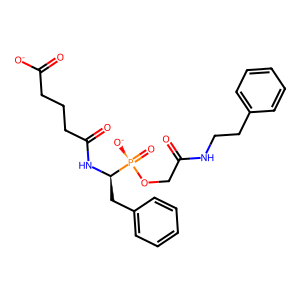

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smi_0 = 'CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@H]3C[C@@H](O)CC(=O)N3Cc3ccc4c(CO)c(OC)ccc4c3)[C@H]21'
smi_1 = 'O=C([O-])CCCC(=O)N[C@H](Cc1ccccc1)[P@@](=O)([O-])OCC(=O)NCCc1ccccc1'
smi_2 = ''
mol = Chem.MolFromSmiles(smi_1)
Draw.MolToImage(mol)
